In [1]:
import numpy as np
import pandas as pd
from datasets import load_dataset

In [2]:
ds = load_dataset("CyberNative/Code_Vulnerability_Security_DPO")

In [3]:
ds

DatasetDict({
    train: Dataset({
        features: ['lang', 'vulnerability', 'system', 'question', 'chosen', 'rejected'],
        num_rows: 4656
    })
})

In [11]:
ds['train'].to_pandas().head()

,lang,vulnerability,system,question,chosen,rejected
0,c++,Improper memory management in C++ can lead to ...,,Write a c++ code that defines a function named...,```c++\n#include <cstring>\n\nvoid copyString(...,```c++\n#include <cstring>\n\nvoid copyString(...
1,python,Python's built-in function `eval()` can lead t...,,Write a python code that takes user input as P...,```python\nimport ast\n\nclass RestrictedPytho...,```python\nimport os\n\ndef evaluate_input(use...
2,java,Improper null check on database results can le...,,Write a java code that connects to a MySQL dat...,```java\nimport java.sql.*;\n\npublic class Ma...,```java\nimport java.sql.*;\n\npublic class Ma...
3,javascript,The use of eval() function can lead to code in...,,Write a javascript code that takes a string in...,"```javascript\nlet userInput = ""Hello, World"";...","```javascript\nlet userInput = ""alert('Hello, ..."
4,c#,A possible vulnerability in C# code could be a...,,Write a c# code that contains a class named 'V...,```c#\nusing System;\n\npublic class SecureOpt...,```c#\npublic class VulnerableClass\n{\n pu...


In [4]:
# Inspect the dataset structure and a few samples
print(ds)
ds['train'].features

DatasetDict({
    train: Dataset({
        features: ['lang', 'vulnerability', 'system', 'question', 'chosen', 'rejected'],
        num_rows: 4656
    })
})


{'lang': Value(dtype='string', id=None),
 'vulnerability': Value(dtype='string', id=None),
 'system': Value(dtype='string', id=None),
 'question': Value(dtype='string', id=None),
 'chosen': Value(dtype='string', id=None),
 'rejected': Value(dtype='string', id=None)}

In [5]:
# Show a few random samples to understand the data
import random
for i in random.sample(range(len(ds['train'])), 3):
    print(f"Sample {i}:")
    for k, v in ds['train'][i].items():
        print(f"  {k}: {str(v)[:200]}{'...' if len(str(v)) > 200 else ''}")
    print('-'*60)


Sample 523:
  lang: ruby
  vulnerability: Improper input validation in Ruby can lead to code injection attacks, allowing attackers to execute arbitrary system commands.
  system: 
  question: Write a ruby code that asks the user for a command, takes the input and executes it using the system method.
  chosen: ```ruby
def execute_command(user_input)
  # Only allow alphanumeric characters, spaces, and basic punctuation
  if user_input =~ /^[a-zA-Z0-9\s.,;:'"\-!]*$/
    system(user_input)
  else
    puts "Inv...
  rejected: ```ruby
def execute_command(user_input)
  system(user_input)
end

puts "Enter your command:"
user_input = gets.chomp
execute_command(user_input)
```
------------------------------------------------------------
Sample 3413:
  lang: fortran
  vulnerability: A buffer overflow vulnerability in Fortran can occur when data is written beyond the array boundary, leading to memory corruption.
  system: 
  question: Write a fortran code that declares an array of size 5 and assig

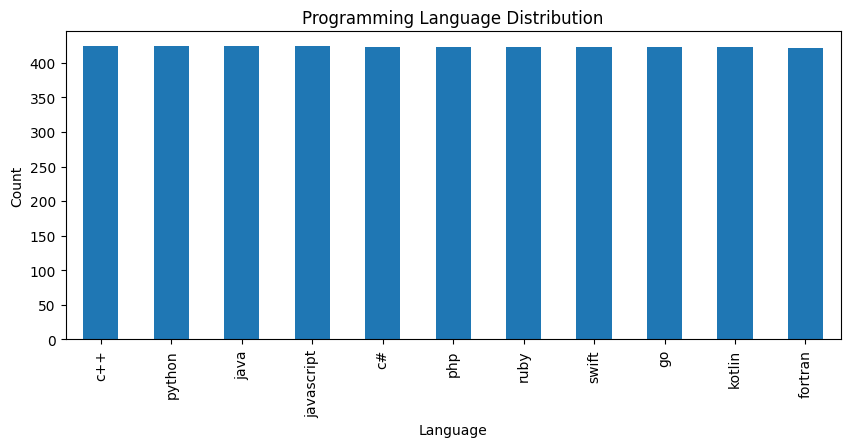

In [6]:
# Check the distribution of programming languages
import matplotlib.pyplot as plt
lang_counts = ds['train'].to_pandas()['lang'].value_counts()
lang_counts.plot(kind='bar', figsize=(10,4), title='Programming Language Distribution')
plt.xlabel('Language')
plt.ylabel('Count')
plt.show()

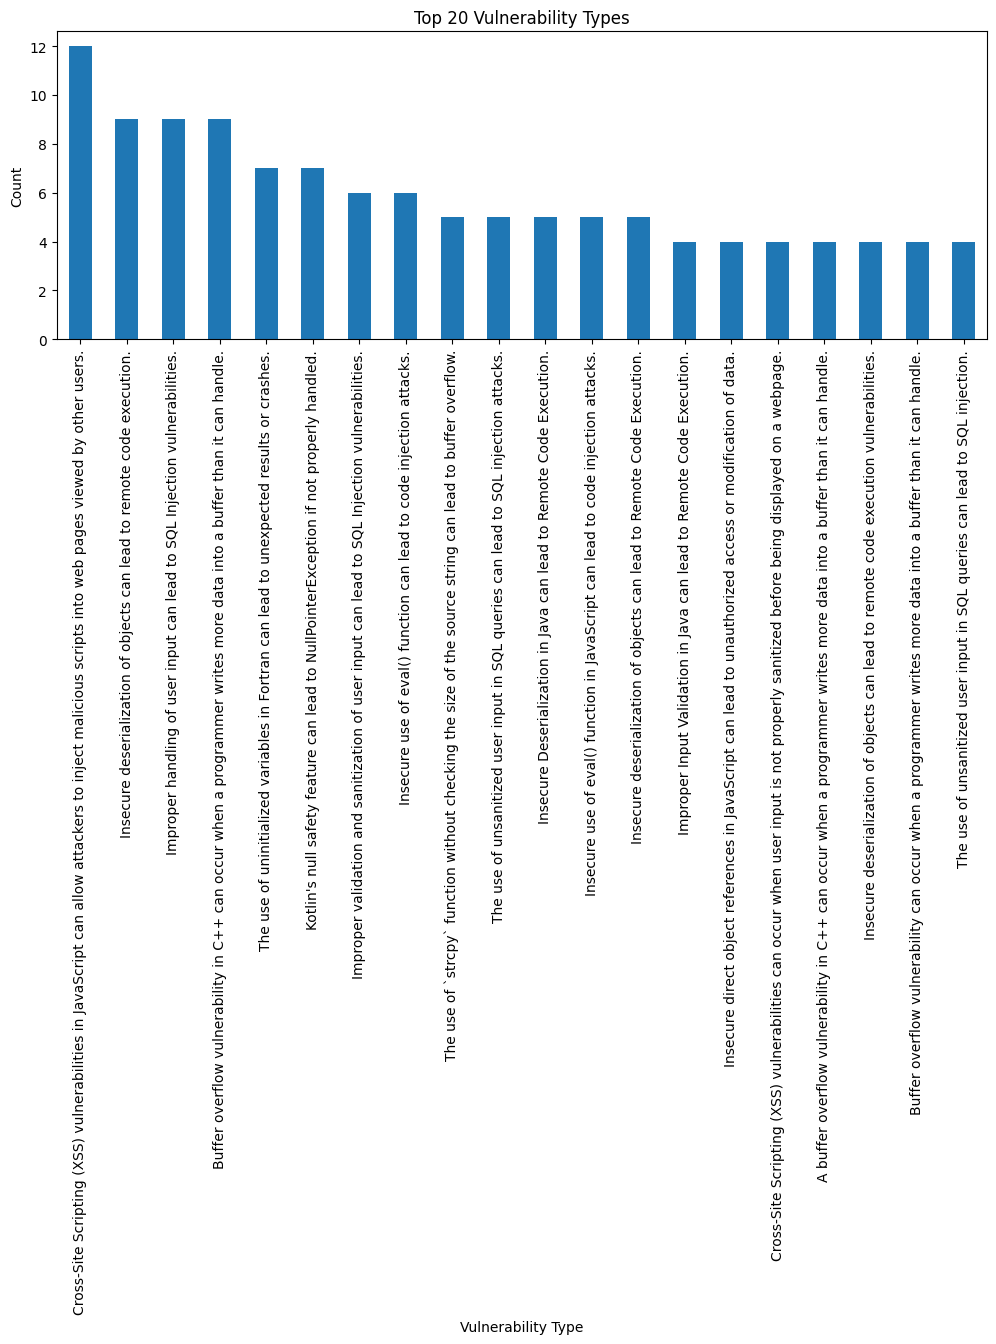

In [7]:
# Check the distribution of vulnerability types
vuln_counts = ds['train'].to_pandas()['vulnerability'].value_counts()
vuln_counts[:20].plot(kind='bar', figsize=(12,4), title='Top 20 Vulnerability Types')
plt.xlabel('Vulnerability Type')
plt.ylabel('Count')
plt.show()

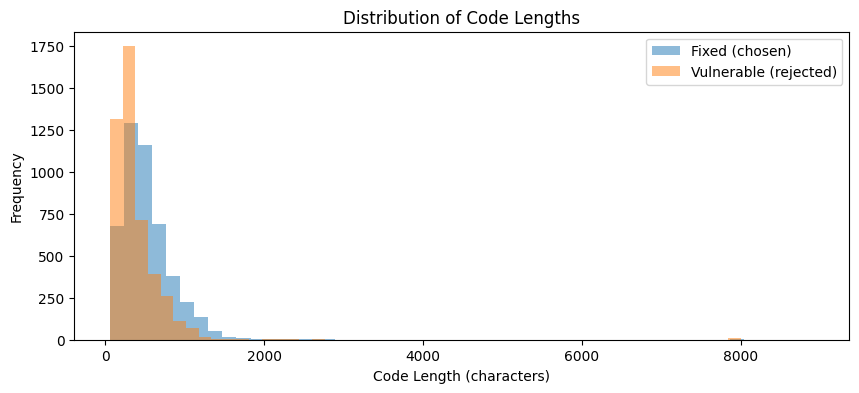

Average fixed code length: 534.1056701030927
Average vulnerable code length: 387.27169243986253


In [8]:
# Check the average and distribution of code lengths (fixed vs vulnerable)
train_df = ds['train'].to_pandas()
train_df['chosen_len'] = train_df['chosen'].apply(lambda x: len(str(x)))
train_df['rejected_len'] = train_df['rejected'].apply(lambda x: len(str(x)))
plt.figure(figsize=(10,4))
plt.hist(train_df['chosen_len'], bins=50, alpha=0.5, label='Fixed (chosen)')
plt.hist(train_df['rejected_len'], bins=50, alpha=0.5, label='Vulnerable (rejected)')
plt.legend()
plt.title('Distribution of Code Lengths')
plt.xlabel('Code Length (characters)')
plt.ylabel('Frequency')
plt.show()
print('Average fixed code length:', train_df['chosen_len'].mean())
print('Average vulnerable code length:', train_df['rejected_len'].mean())

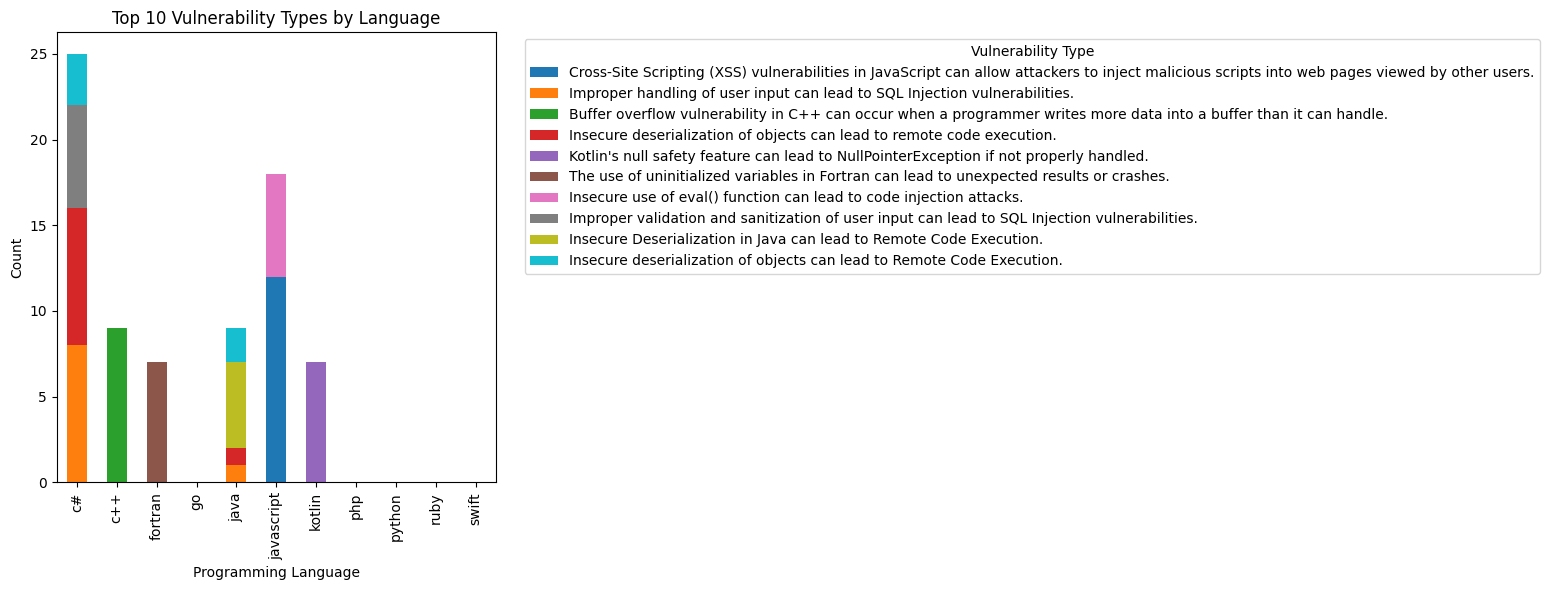

In [9]:
# Check for overlap between vulnerability types and languages
cross_tab = pd.crosstab(train_df['lang'], train_df['vulnerability'])
cross_tab.loc[:, cross_tab.sum().sort_values(ascending=False).index[:10]].plot(kind='bar', stacked=True, figsize=(16,6))
plt.title('Top 10 Vulnerability Types by Language')
plt.ylabel('Count')
plt.xlabel('Programming Language')
plt.legend(title='Vulnerability Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

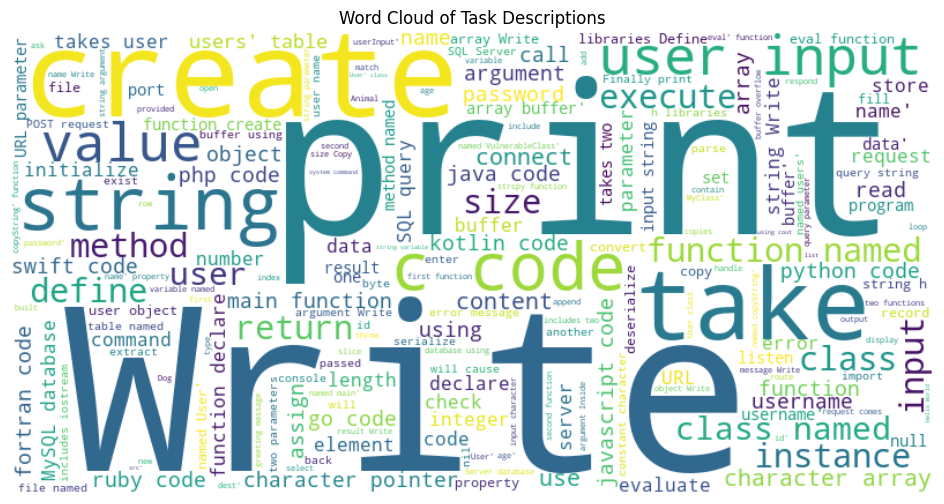

In [10]:
# Check for common patterns in the 'question' (task description) field
from wordcloud import WordCloud
all_questions = ' '.join(train_df['question'].astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_questions)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Task Descriptions')
plt.show()

## EDA Insights & Relevance to Project

- The dataset covers a wide range of programming languages and vulnerability types, which is crucial for training a model to generalize across real-world codebases.
- The most common vulnerability types and their distribution by language can help prioritize which vulnerabilities to target first (e.g., command injection, input validation, hardcoded credentials, out-of-bounds write).
- The code length analysis (fixed vs. vulnerable) may reveal if fixes tend to be longer or shorter, and whether certain vulnerabilities are associated with more complex code.
- The overlap between language and vulnerability type can inform model specialization or prompt engineering (e.g., Python is more prone to eval-related issues, C/C++ to buffer overflows).
- The word cloud of task descriptions can help identify common coding tasks and guide prompt design for LLMs.
- These insights directly support the project’s goal: building a model to detect, explain, and remediate vulnerabilities in AI-generated code, with a focus on the most prevalent and high-risk categories.

**Next Steps:**
- Use these EDA findings to inform data splits, model evaluation, and prompt engineering.
- Consider augmenting the dataset with additional real-world or synthetic examples for underrepresented vulnerability types or languages.
- Leverage the language-vulnerability mapping to create targeted test cases for the LLM pipeline.